## Topic classification using BERT Embeddings

In [23]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
selected_issues = [
    "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
				"National Security, Defence, Foreign Affairs", "Veterans and Military"
  ]
df = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df.groupby("issue")["text"].count()

issue
Education                                      1411
Energy and Environment                         2380
Health Care and Social Security                2930
Jobs and the Economy                           2333
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

In [24]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words_path = "./SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df.loc[:, "text"] = df["text"].apply(lambda text: preprocess_text(text, stopwords))
df = df[df["text"] != ""]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We want to use BERT solely for generating embeddings and then feed those embeddings into a separate neural network for classification, so we freeze the BERT model and use it as a feature extractor. This approach significantly reduces computational cost compared to fine-tuning the entire BERT model.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['issue'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = sbert_model.encode(train_texts.tolist(), convert_to_tensor=True)
val_embeddings = sbert_model.encode(val_texts.tolist(), convert_to_tensor=True)

train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)

train_dataset = TensorDataset(train_embeddings, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings, val_labels_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [26]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np


class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

early_stopper = EarlyStopper(patience=3, min_delta=10)

def train(classifier, criterion, optimizer, train_loader, epochs=30):
	losses = []
	for epoch in range(epochs):  # Train for 10 epochs
					classifier.train()
					for batch in train_loader:
									optimizer.zero_grad()

									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									loss = criterion(outputs, labels)
									loss.backward()
									optimizer.step()
									

					final_loss = loss.item()
					print(f"Epoch {epoch + 1}, Loss: {final_loss}")
					losses.append(final_loss)
					if early_stopper.early_stop(final_loss):
						break
	return losses

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [34]:
def evaluate(classifier, val_loader):
	classifier.eval()
	all_predictions = []
	all_labels = []
	with torch.no_grad():
					for batch in val_loader:
									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									predictions = torch.argmax(outputs, dim=-1)

									all_predictions.extend(predictions.cpu().numpy())
									all_labels.extend(labels.cpu().numpy())

	# Generate classification report
	print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

	# Generate confusion matrix
	cm = confusion_matrix(all_labels, all_predictions)
	cm_display_labels = label_encoder.classes_

	# Plot confusion matrix
	plt.figure(figsize=(10, 8))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
	plt.xlabel('Predicted Label')
	plt.ylabel('True Label')
	plt.title('Confusion Matrix')
	plt.show()

In [35]:
model_simple = SimpleNN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_simple.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model_simple.parameters(), lr=1e-4)

In [36]:
train(model_simple, criterion_cros_entr_loss, optimizer_adam, train_loader, 30)

Epoch 1, Loss: 1.5141198635101318
Epoch 2, Loss: 1.0687450170516968
Epoch 3, Loss: 0.9230852127075195
Epoch 4, Loss: 0.6448989510536194
Epoch 5, Loss: 0.747454047203064
Epoch 6, Loss: 0.42128807306289673
Epoch 7, Loss: 0.733295738697052
Epoch 8, Loss: 0.6475574970245361
Epoch 9, Loss: 0.4922952651977539
Epoch 10, Loss: 0.40065866708755493
Epoch 11, Loss: 0.34991776943206787
Epoch 12, Loss: 0.6323243379592896
Epoch 13, Loss: 0.7888278961181641
Epoch 14, Loss: 0.3744577467441559
Epoch 15, Loss: 0.30513796210289
Epoch 16, Loss: 0.3728224039077759
Epoch 17, Loss: 0.4519380033016205
Epoch 18, Loss: 0.43013322353363037
Epoch 19, Loss: 0.4204827547073364
Epoch 20, Loss: 0.29995906352996826
Epoch 21, Loss: 0.10432514548301697
Epoch 22, Loss: 0.6206681132316589
Epoch 23, Loss: 0.161850243806839
Epoch 24, Loss: 0.35479623079299927
Epoch 25, Loss: 0.17094439268112183
Epoch 26, Loss: 0.4059671461582184
Epoch 27, Loss: 0.4397853910923004
Epoch 28, Loss: 0.6579694747924805
Epoch 29, Loss: 0.86370366

[1.5141198635101318,
 1.0687450170516968,
 0.9230852127075195,
 0.6448989510536194,
 0.747454047203064,
 0.42128807306289673,
 0.733295738697052,
 0.6475574970245361,
 0.4922952651977539,
 0.40065866708755493,
 0.34991776943206787,
 0.6323243379592896,
 0.7888278961181641,
 0.3744577467441559,
 0.30513796210289,
 0.3728224039077759,
 0.4519380033016205,
 0.43013322353363037,
 0.4204827547073364,
 0.29995906352996826,
 0.10432514548301697,
 0.6206681132316589,
 0.161850243806839,
 0.35479623079299927,
 0.17094439268112183,
 0.4059671461582184,
 0.4397853910923004,
 0.6579694747924805,
 0.8637036681175232,
 0.49541404843330383]

                                             precision    recall  f1-score   support

                                  Education       0.87      0.85      0.86       282
                     Energy and Environment       0.88      0.93      0.91       476
            Health Care and Social Security       0.89      0.92      0.91       586
                       Jobs and the Economy       0.81      0.77      0.79       467
National Security, Defence, Foreign Affairs       0.89      0.90      0.90       735
                      Veterans and Military       0.85      0.77      0.81       275

                                   accuracy                           0.87      2821
                                  macro avg       0.87      0.86      0.86      2821
                               weighted avg       0.87      0.87      0.87      2821



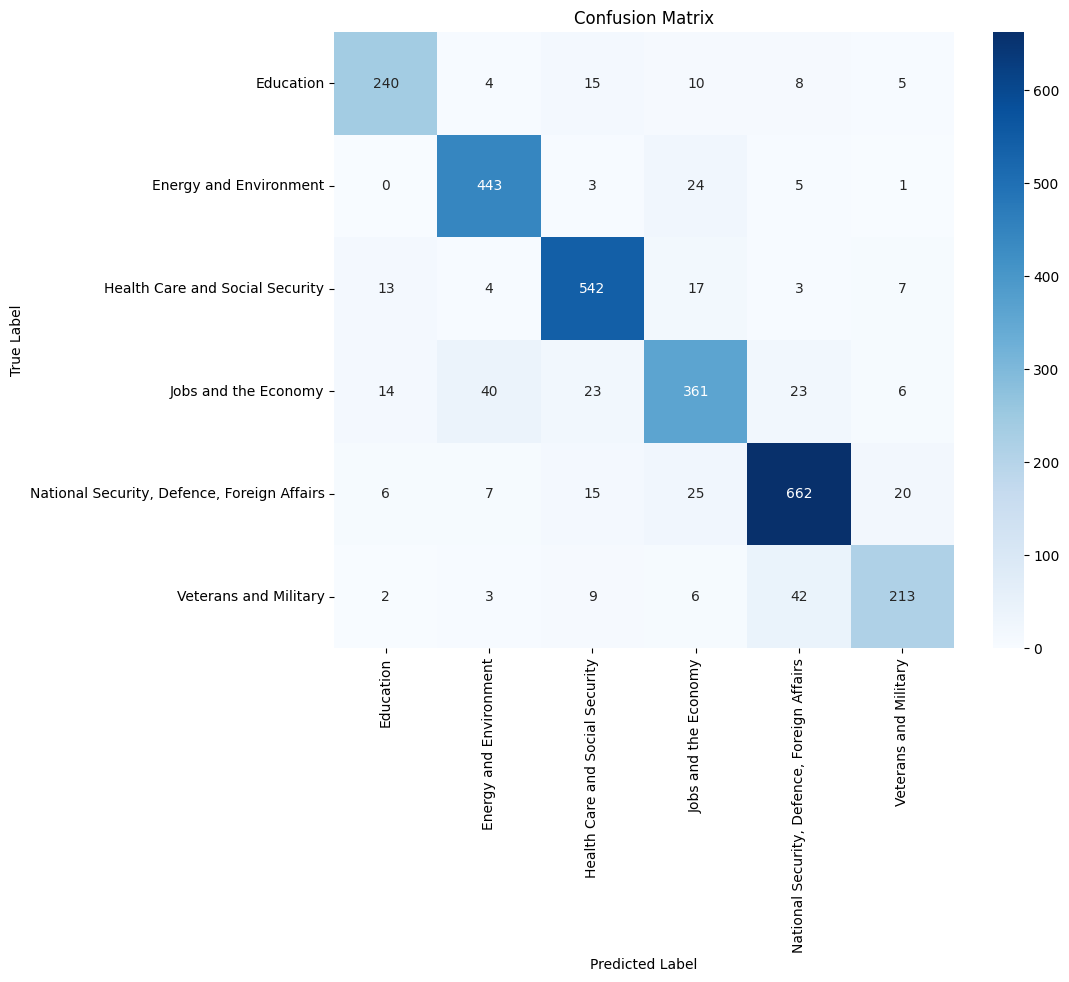

In [37]:
evaluate(model_simple, val_loader)

---

## Slightly more difficult model

In [22]:
class SlightlyMoreDifficultNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SlightlyMoreDifficultNN, self).__init__()
        self.fc = nn.Sequential(
								nn.Linear(input_dim, 256),
								nn.ReLU(),
								nn.Dropout(0.4),
								nn.Linear(256, 128),
								nn.ReLU(),
								nn.Dropout(0.3),
								nn.Linear(128, num_classes)
							)

    def forward(self, x):
        return self.fc(x)

In [35]:
model_more_diff = SlightlyMoreDifficultNN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_more_diff.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam_diff = torch.optim.Adam(model_more_diff.parameters(), lr=5e-5, weight_decay=1e-4)

In [36]:
train(model_more_diff, criterion_cros_entr_loss, optimizer_adam_diff, train_loader, 100)

Epoch 1, Loss: 1.6139532327651978
Epoch 2, Loss: 1.155387282371521
Epoch 3, Loss: 0.9893538355827332
Epoch 4, Loss: 0.9984537959098816
Epoch 5, Loss: 0.763274610042572
Epoch 6, Loss: 0.5343021154403687
Epoch 7, Loss: 0.5736692547798157
Epoch 8, Loss: 0.5798031687736511
Epoch 9, Loss: 0.4103473722934723
Epoch 10, Loss: 0.5381739735603333
Epoch 11, Loss: 0.8336502313613892
Epoch 12, Loss: 0.39812520146369934
Epoch 13, Loss: 0.4629225730895996
Epoch 14, Loss: 0.2749130427837372
Epoch 15, Loss: 0.5817601680755615
Epoch 16, Loss: 0.8028514981269836
Epoch 17, Loss: 0.28791821002960205
Epoch 18, Loss: 0.38961660861968994
Epoch 19, Loss: 0.371189683675766
Epoch 20, Loss: 0.5320854187011719
Epoch 21, Loss: 0.3481283187866211
Epoch 22, Loss: 0.1235765889286995
Epoch 23, Loss: 0.36616265773773193
Epoch 24, Loss: 0.30932867527008057
Epoch 25, Loss: 0.47854602336883545
Epoch 26, Loss: 0.6027555465698242
Epoch 27, Loss: 0.14343523979187012
Epoch 28, Loss: 0.45434296131134033
Epoch 29, Loss: 0.323257

                                             precision    recall  f1-score   support

                                  Education       0.89      0.85      0.87       282
                     Energy and Environment       0.90      0.93      0.92       476
            Health Care and Social Security       0.90      0.93      0.92       586
                       Jobs and the Economy       0.84      0.80      0.82       467
National Security, Defence, Foreign Affairs       0.90      0.93      0.91       735
                      Veterans and Military       0.87      0.80      0.84       275

                                   accuracy                           0.89      2821
                                  macro avg       0.88      0.87      0.88      2821
                               weighted avg       0.89      0.89      0.89      2821



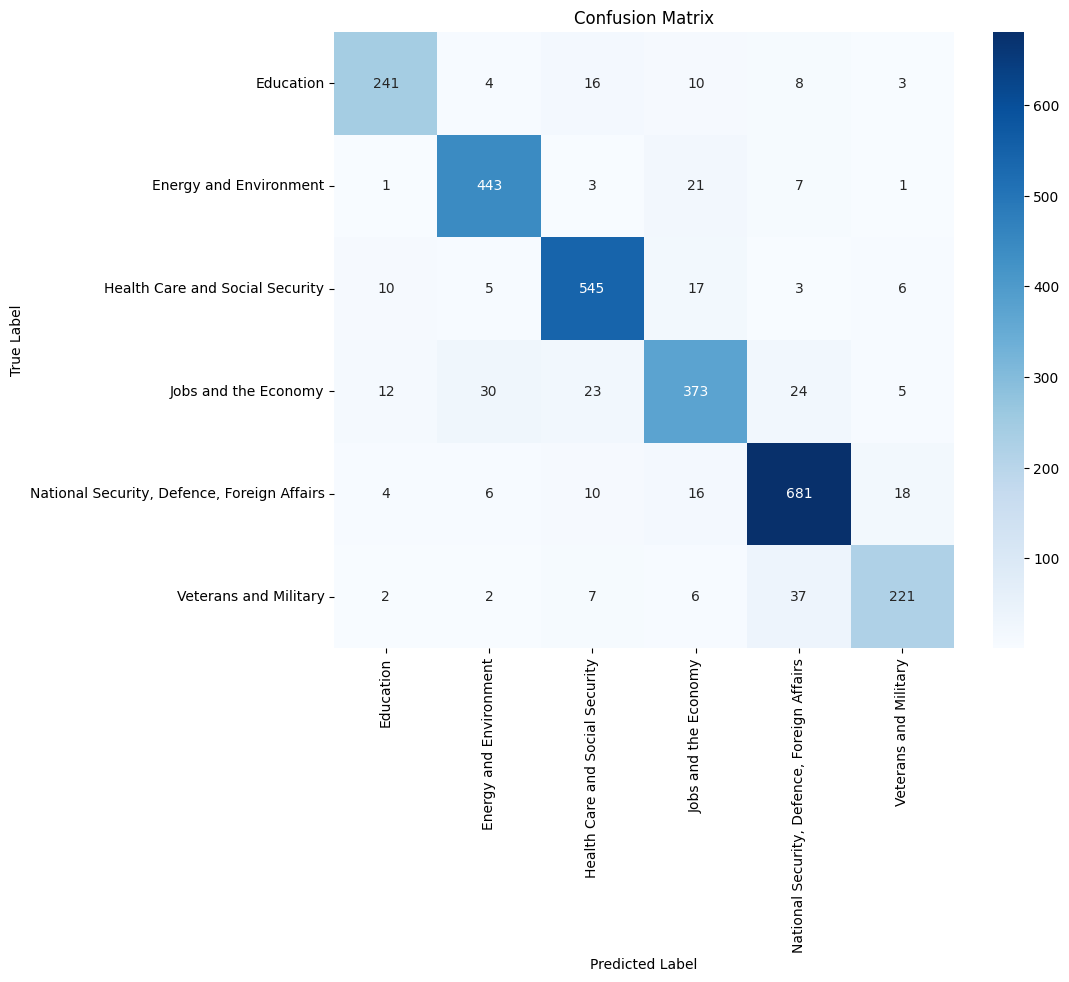

In [37]:
evaluate(model_more_diff, val_loader)

---

## 3rd model - 3 hidden layers

In [28]:
early_stopper = EarlyStopper(patience=3, min_delta=10)
class ImprovedNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ImprovedNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [29]:
model_improved = ImprovedNN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam_im = torch.optim.Adam(model_improved.parameters(), lr=1e-4, weight_decay=1e-4)

In [30]:
losses = train(model_improved, criterion_cros_entr_loss, optimizer_adam_im, train_loader, 300)

Epoch 1, Loss: 1.6048297882080078
Epoch 2, Loss: 1.5065561532974243
Epoch 3, Loss: 0.7508420348167419
Epoch 4, Loss: 0.32611408829689026
Epoch 5, Loss: 0.4852459132671356
Epoch 6, Loss: 0.7800977230072021
Epoch 7, Loss: 0.22559520602226257
Epoch 8, Loss: 0.5288650989532471
Epoch 9, Loss: 0.4548630118370056
Epoch 10, Loss: 0.2865111827850342
Epoch 11, Loss: 0.17060790956020355
Epoch 12, Loss: 0.371768593788147
Epoch 13, Loss: 0.5195513963699341
Epoch 14, Loss: 0.3312924802303314
Epoch 15, Loss: 0.32671162486076355
Epoch 16, Loss: 0.8326070308685303
Epoch 17, Loss: 0.15380896627902985
Epoch 18, Loss: 0.1125112771987915
Epoch 19, Loss: 0.2426874041557312
Epoch 20, Loss: 0.20517128705978394
Epoch 21, Loss: 0.16038498282432556
Epoch 22, Loss: 0.8941485285758972
Epoch 23, Loss: 0.19187061488628387
Epoch 24, Loss: 0.48939836025238037
Epoch 25, Loss: 0.17702186107635498
Epoch 26, Loss: 0.6579806208610535
Epoch 27, Loss: 0.1594163030385971
Epoch 28, Loss: 0.10992974787950516
Epoch 29, Loss: 0.1

                                             precision    recall  f1-score   support

                                  Education       0.91      0.88      0.90       282
                     Energy and Environment       0.90      0.95      0.92       476
            Health Care and Social Security       0.91      0.94      0.93       586
                       Jobs and the Economy       0.88      0.85      0.87       467
National Security, Defence, Foreign Affairs       0.93      0.94      0.94       735
                      Veterans and Military       0.92      0.85      0.88       275

                                   accuracy                           0.91      2821
                                  macro avg       0.91      0.90      0.91      2821
                               weighted avg       0.91      0.91      0.91      2821



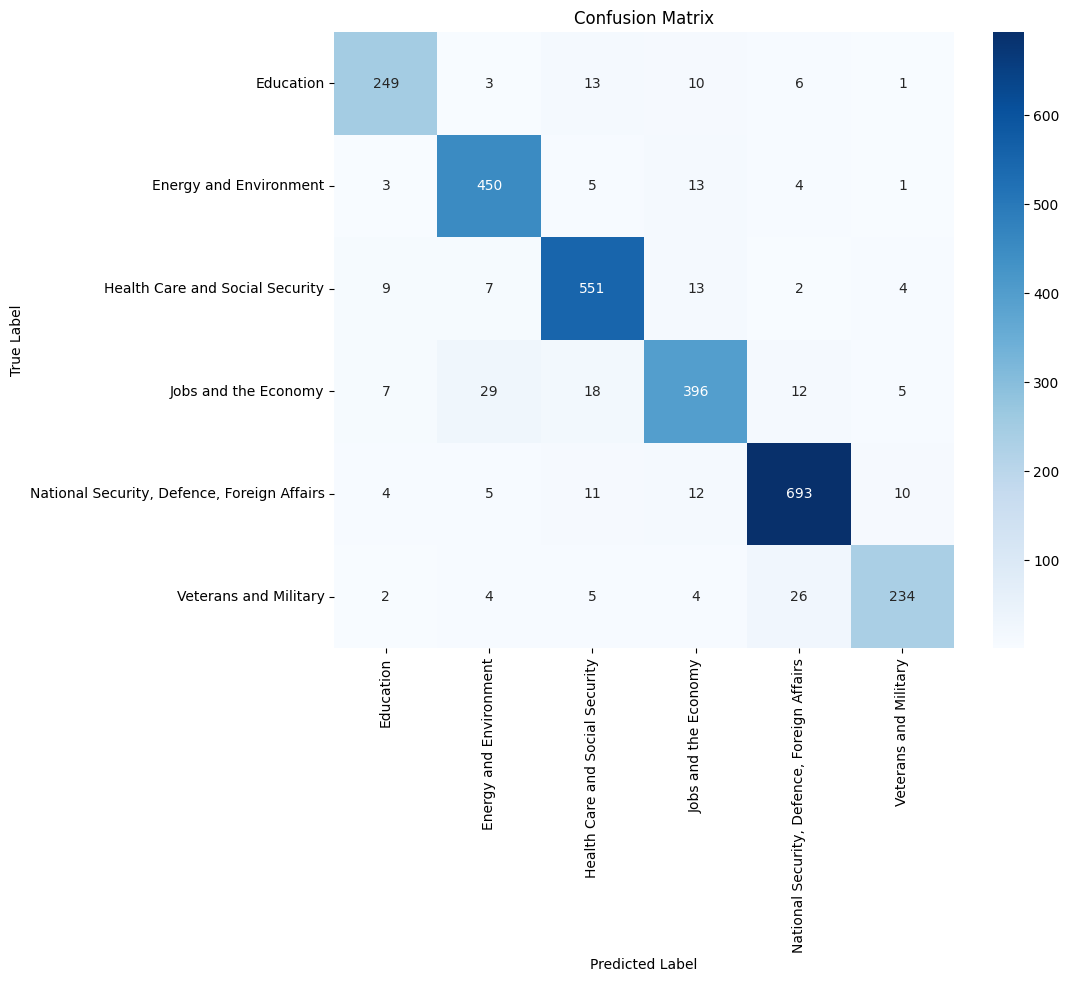

In [31]:
evaluate(model_improved, val_loader)

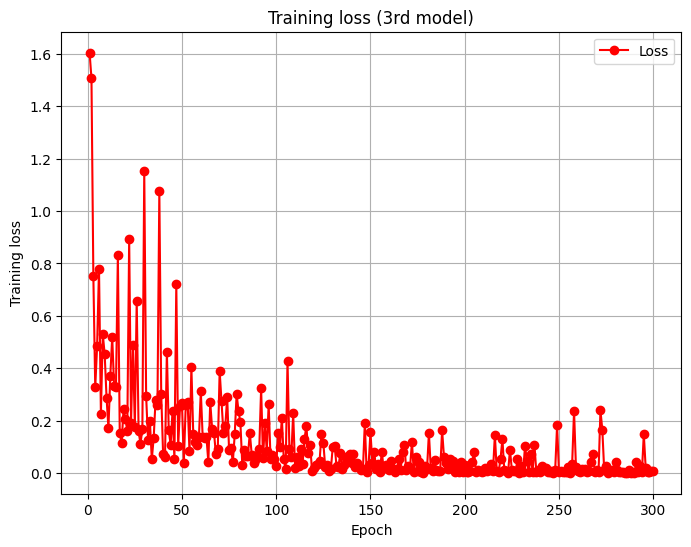

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, marker='o', linestyle='-', color='r', label='Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (3rd model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()

----

## 4th model - 4 hidden layers

In [19]:
early_stopper = EarlyStopper(patience=3, min_delta=10)
class Improved2NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved2NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [20]:
model_improved2 = Improved2NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved2.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam_im2 = torch.optim.Adam(model_improved2.parameters(), lr=1e-4, weight_decay=1e-4)

In [21]:
losses = train(model_improved2, criterion_cros_entr_loss, optimizer_adam_im2, train_loader, 300)

Epoch 1, Loss: 1.6132508516311646
Epoch 2, Loss: 0.924748420715332
Epoch 3, Loss: 1.3580515384674072
Epoch 4, Loss: 1.2288833856582642
Epoch 5, Loss: 0.6600192785263062
Epoch 6, Loss: 0.5161024332046509
Epoch 7, Loss: 0.7991916537284851
Epoch 8, Loss: 0.4797661006450653
Epoch 9, Loss: 0.5968034267425537
Epoch 10, Loss: 0.7091500759124756
Epoch 11, Loss: 1.2153573036193848
Epoch 12, Loss: 0.43021291494369507
Epoch 13, Loss: 0.5299837589263916
Epoch 14, Loss: 0.2276889532804489
Epoch 15, Loss: 0.5982696413993835
Epoch 16, Loss: 0.2076318860054016
Epoch 17, Loss: 0.1709485948085785
Epoch 18, Loss: 0.4732073247432709
Epoch 19, Loss: 0.5914095640182495
Epoch 20, Loss: 0.3545718193054199
Epoch 21, Loss: 0.33334892988204956
Epoch 22, Loss: 0.5239875316619873
Epoch 23, Loss: 0.7246741056442261
Epoch 24, Loss: 0.4314013123512268
Epoch 25, Loss: 0.2474878430366516
Epoch 26, Loss: 0.2837788164615631
Epoch 27, Loss: 0.24343988299369812
Epoch 28, Loss: 0.2939678430557251
Epoch 29, Loss: 0.287199079

                                             precision    recall  f1-score   support

                                  Education       0.89      0.84      0.87       282
                     Energy and Environment       0.90      0.91      0.91       476
            Health Care and Social Security       0.91      0.92      0.92       586
                       Jobs and the Economy       0.85      0.81      0.83       467
National Security, Defence, Foreign Affairs       0.89      0.96      0.92       735
                      Veterans and Military       0.91      0.84      0.87       275

                                   accuracy                           0.89      2821
                                  macro avg       0.89      0.88      0.89      2821
                               weighted avg       0.89      0.89      0.89      2821



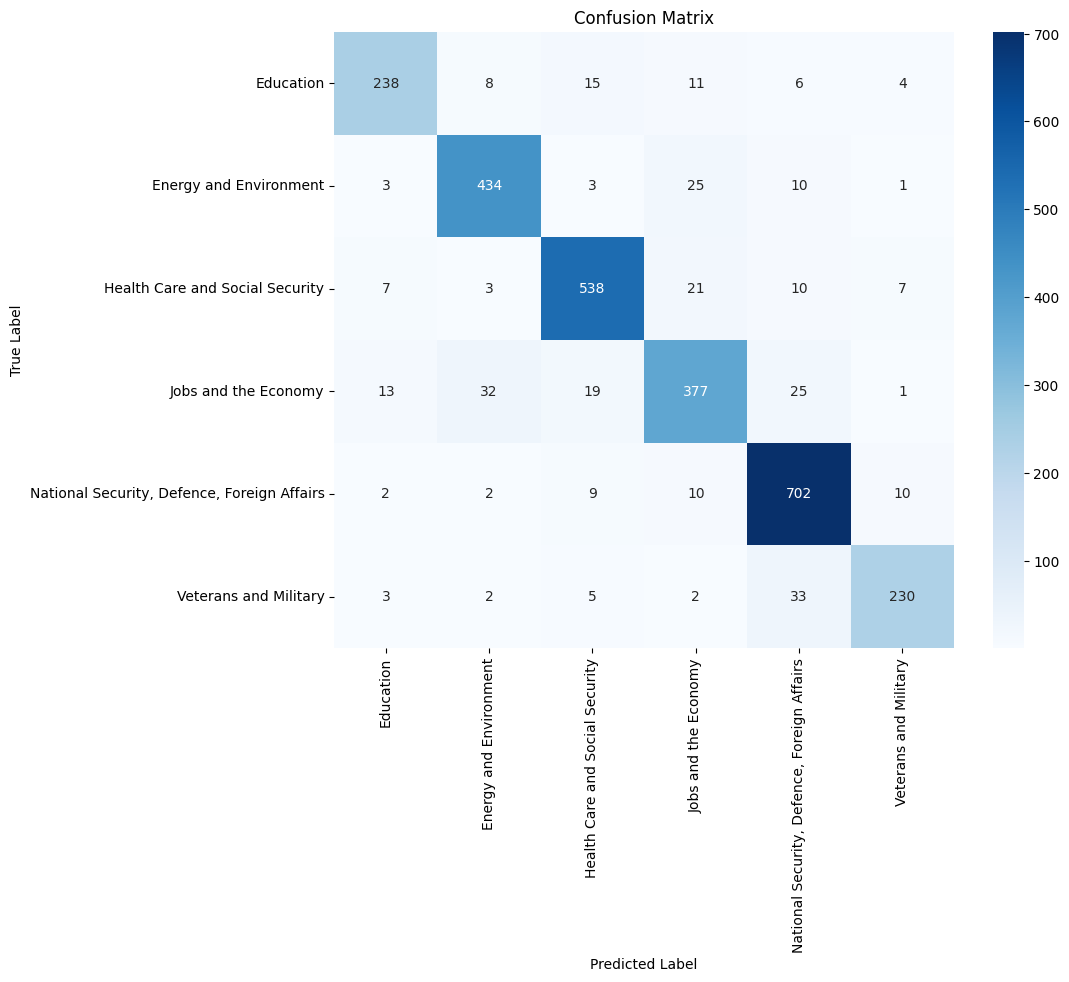

In [22]:
evaluate(model_improved2, val_loader)

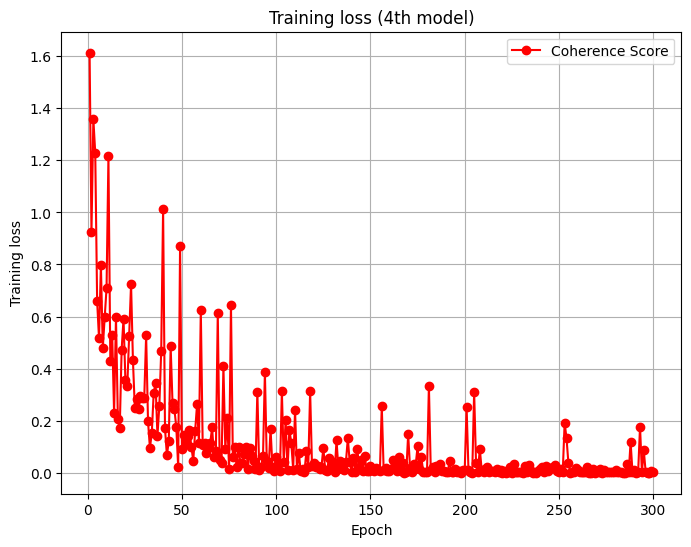

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, marker='o', linestyle='-', color='r', label='Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (4th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()

---

## 5th model - 5 hidden layers

In [16]:
class Improved3NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved3NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

model_improved3 = Improved3NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved3.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam_im3 = torch.optim.Adam(model_improved3.parameters(), lr=1e-4, weight_decay=1e-4)

losses = train(model_improved3, criterion_cros_entr_loss, optimizer_adam_im3, train_loader, 400)

Epoch 1, Loss: 1.7114930152893066
Epoch 2, Loss: 1.2307380437850952
Epoch 3, Loss: 1.3039368391036987
Epoch 4, Loss: 1.1868743896484375
Epoch 5, Loss: 1.0272107124328613
Epoch 6, Loss: 0.9756835103034973
Epoch 7, Loss: 0.6110693216323853
Epoch 8, Loss: 0.9508343935012817
Epoch 9, Loss: 0.6403736472129822
Epoch 10, Loss: 0.6844517588615417
Epoch 11, Loss: 0.66390460729599
Epoch 12, Loss: 1.0506380796432495
Epoch 13, Loss: 1.1765035390853882
Epoch 14, Loss: 0.4467361271381378
Epoch 15, Loss: 1.128602147102356
Epoch 16, Loss: 1.0066344738006592
Epoch 17, Loss: 0.7136633992195129
Epoch 18, Loss: 0.324453204870224
Epoch 19, Loss: 0.5141370296478271
Epoch 20, Loss: 0.3368609547615051
Epoch 21, Loss: 0.2898501455783844
Epoch 22, Loss: 0.3067623972892761
Epoch 23, Loss: 0.22687523066997528
Epoch 24, Loss: 0.6256994009017944
Epoch 25, Loss: 0.4891049563884735
Epoch 26, Loss: 0.37886837124824524
Epoch 27, Loss: 0.386215478181839
Epoch 28, Loss: 0.5583332777023315
Epoch 29, Loss: 0.48111099004745

                                             precision    recall  f1-score   support

                                  Education       0.93      0.83      0.88       282
                     Energy and Environment       0.90      0.93      0.92       476
            Health Care and Social Security       0.92      0.93      0.92       586
                       Jobs and the Economy       0.83      0.84      0.83       467
National Security, Defence, Foreign Affairs       0.93      0.95      0.94       735
                      Veterans and Military       0.88      0.85      0.86       275

                                   accuracy                           0.90      2821
                                  macro avg       0.90      0.89      0.89      2821
                               weighted avg       0.90      0.90      0.90      2821



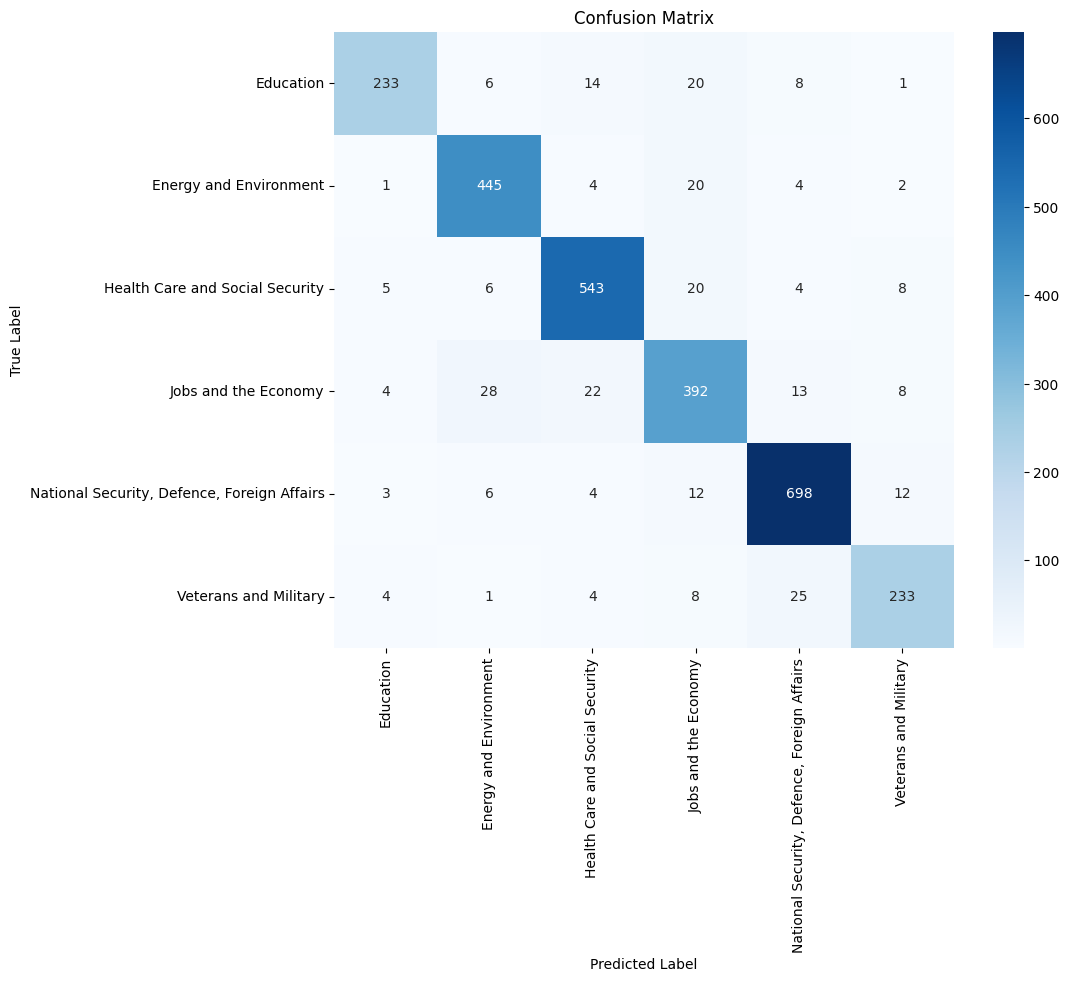

In [17]:
evaluate(model_improved3, val_loader)

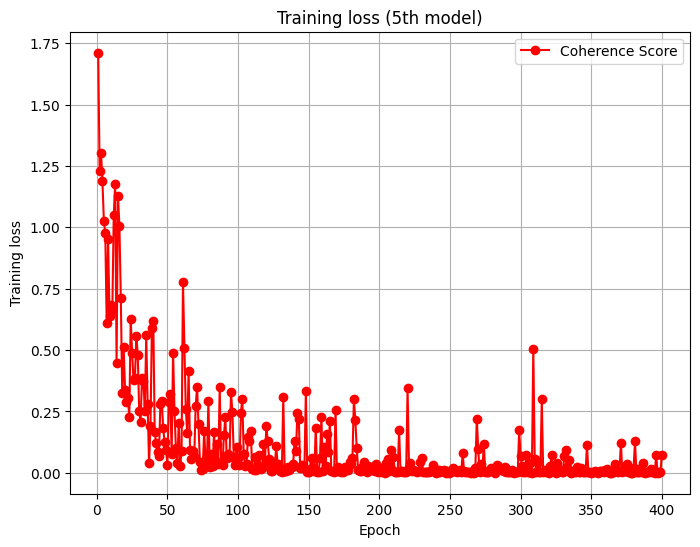

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, marker='o', linestyle='-', color='r', label='Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (5th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()

---

## 6th model - 5th model with weighted loss

In [45]:
class Improved3NN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Improved3NN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

from sklearn.utils.class_weight import compute_class_weight
labels_tensor = torch.concat([train_labels_tensor, val_labels_tensor]) 
class_weights = compute_class_weight('balanced', classes=np.unique(labels_tensor), y=labels_tensor.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
print(class_weights)

model_improved6 = Improved3NN(input_dim=train_embeddings.size(1), num_classes=len(df['issue'].unique()))
model_improved6.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss(weight=class_weights)
optimizer_adam_im6 = torch.optim.Adam(model_improved6.parameters(), lr=1e-4, weight_decay=1e-4)

losses = train(model_improved6, criterion_cros_entr_loss, optimizer_adam_im6, train_loader, 400)

tensor([1.6658, 0.9876, 0.8022, 1.0075, 0.6399, 1.7082])
Epoch 1, Loss: 1.5872403383255005
Epoch 2, Loss: 1.4281569719314575
Epoch 3, Loss: 1.035093903541565
Epoch 4, Loss: 1.2635233402252197
Epoch 5, Loss: 1.1390992403030396
Epoch 6, Loss: 0.9082653522491455
Epoch 7, Loss: 1.0254226922988892
Epoch 8, Loss: 1.1431164741516113
Epoch 9, Loss: 0.8087693452835083
Epoch 10, Loss: 1.0674071311950684
Epoch 11, Loss: 0.9280381202697754
Epoch 12, Loss: 0.9166859984397888
Epoch 13, Loss: 0.5822851061820984
Epoch 14, Loss: 0.8138269782066345
Epoch 15, Loss: 0.5821782350540161
Epoch 16, Loss: 0.6293289661407471
Epoch 17, Loss: 0.43861833214759827
Epoch 18, Loss: 1.0250471830368042
Epoch 19, Loss: 0.5244545340538025
Epoch 20, Loss: 0.8314298391342163
Epoch 21, Loss: 1.4766045808792114
Epoch 22, Loss: 0.520815908908844
Epoch 23, Loss: 0.5744639039039612
Epoch 24, Loss: 0.9645851850509644
Epoch 25, Loss: 0.9364235401153564
Epoch 26, Loss: 0.7450999617576599
Epoch 27, Loss: 0.5286290049552917
Epoch 28

                                             precision    recall  f1-score   support

                                  Education       0.88      0.87      0.87       282
                     Energy and Environment       0.90      0.93      0.91       476
            Health Care and Social Security       0.92      0.92      0.92       586
                       Jobs and the Economy       0.82      0.83      0.83       467
National Security, Defence, Foreign Affairs       0.93      0.91      0.92       735
                      Veterans and Military       0.85      0.87      0.86       275

                                   accuracy                           0.89      2821
                                  macro avg       0.89      0.89      0.89      2821
                               weighted avg       0.89      0.89      0.89      2821



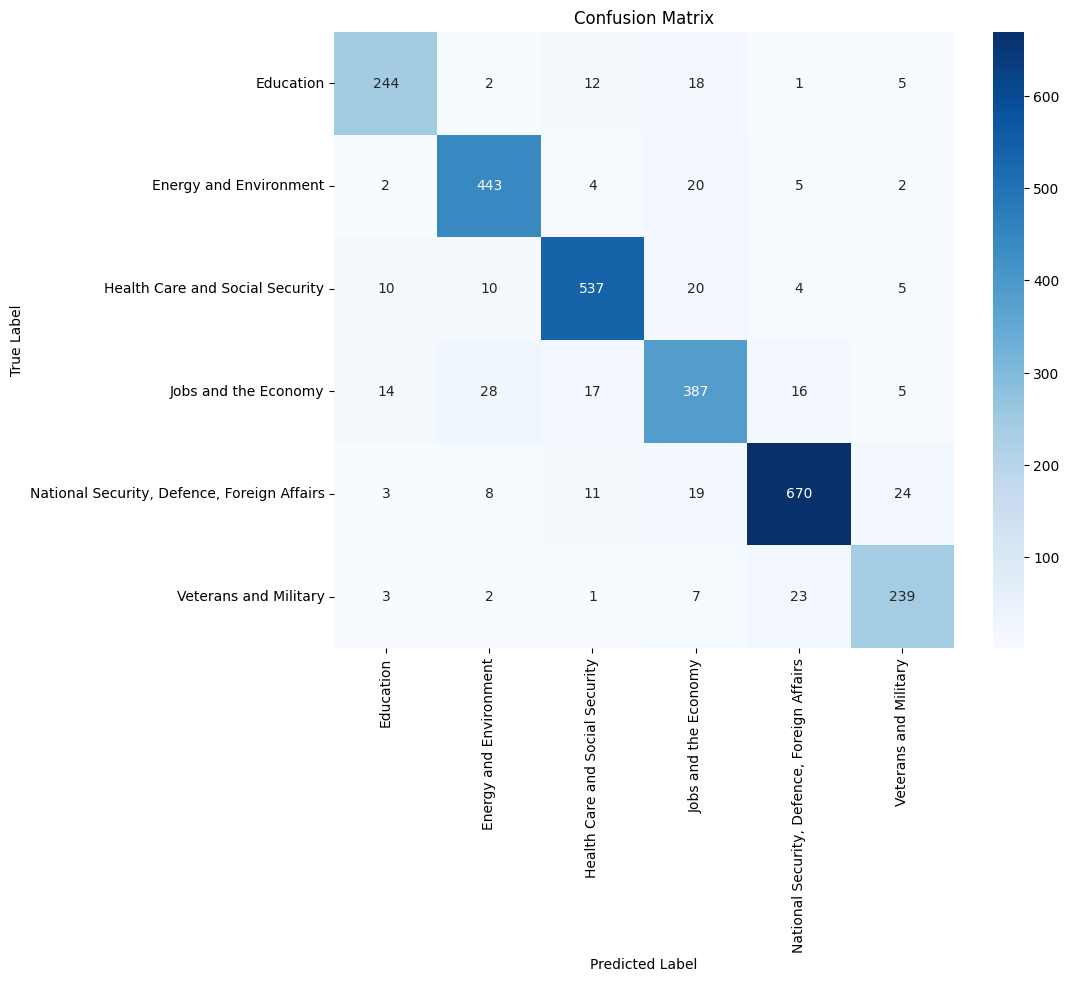

In [42]:
evaluate(model_improved6, val_loader)

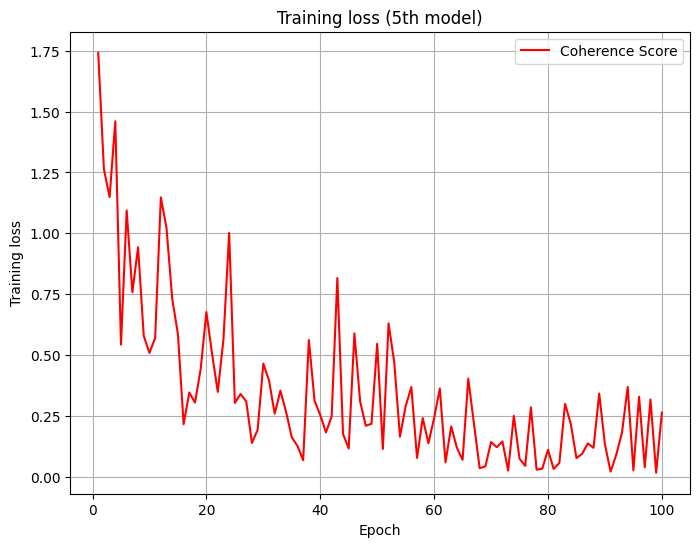

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(list(range(1, len(losses)+1)), losses, linestyle='-', color='r', label='Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss (5th model)')
plt.legend()

# Show the plot
plt.grid()
plt.show()